In [1]:
%load_ext tikzmagic
%matplotlib inline

# 레버리지와 아웃라이어

지금까지는 회귀분석의 성능을 향상시키기 위해 독립변수를 선택하는 방법을 공부했다. 이 절에서는 개별적인 데이터 레코드를 분석하는 방법을 학습힌다. 즉 지금까지 독립변수행렬 $X$의 열을 선택하거나 제거하는 방법을 공부했다면 이제는 독립변수행렬 $X$의 행을 조사하고 선택하는 방법을 알아본다. 

예제로는 보스턴 집값을 lstat 독립변수를 사용하여 선형회귀분석한 결과를 사용한다. 다만 여기에서는 전체 데이터를 다 사용하는 것이 아니라 일부(20개) 데이터 레코드만을 사용하여 회귀분석을 한다.

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
boston20 = boston.iloc[345:365]  # 일부 데이터만 사용

model20 = sm.OLS.from_formula("medv ~ scale(rm)", boston20)
result20 = model20.fit()
print(result20.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4.269
Date:                Mon, 01 Aug 2022   Prob (F-statistic):             0.0535
Time:                        20:39:06   Log-Likelihood:                -50.606
No. Observations:                  20   AIC:                             105.2
Df Residuals:                      18   BIC:                             107.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.6300      0.716     30.202      0.0

seaborn 패키지의 `regplot` 함수로 선형회귀분석 결과를 그림으로 그리면 다음 그림과 같다. 이 그림에서는 0번 데이터 레코드부터 19번 데이터 레코드까지 20개의 데이터 레코드 각각에 대해 인덱스 번호를 붙어서 표시하였다.

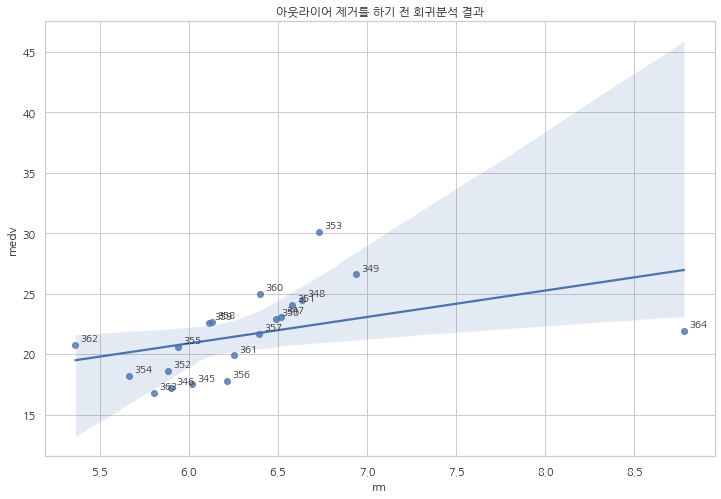

In [3]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.regplot(x="rm", y="medv", data=boston20)
for i, r in boston20.iterrows():
    plt.annotate(i, (r.rm + 0.03, r.medv + 0.3))
plt.title("아웃라이어 제거를 하기 전 회귀분석 결과")
plt.show()

## 레버리지

선형회귀분석을 실시하고 나면 찾아낸 가중치에 따른 예측값 $\hat{y}$을 다음 공식으로 계산할 수 있다. 

$$
\hat{y} = X \hat{w} = X(X^TX)^{-1}X^T y
$$

위 식에서 $y$ 앞에 있는 $X(X^TX)^{-1}X^T$ 행렬을 <b>영향도행렬(influence matrix)</b> 혹은 <b>hat행렬(hat-matrix)</b>이라고 부르고 기호로 $H$라고 쓴다.

$$
H = X(X^TX)^{-1}X^T
$$

데이터의 개수가 $N$개일 때 영향도행렬은 $N\times N$ 크기의 행렬이 된다.

영향도행렬에서 가장 중요한 부분은 대각성분이다. 영향도행렬 $H$의 $i$번째 대각성분 $H_{ii}$을 <b>레버리지(leverage)</b> $h_i$라고 부른다.

$$
h_i = H_{ii}
$$

영향도행렬의 크기가 $N\times N$이므로 레버리지의 개수는 데이터 개수와 같다. 즉, $i$번째 데이터에 대해 $i$번째 레버리지가 대응되는 구조로 각각의 데이터는 하나의 레버리지 값을 가진다. 

$$
(x_i, y_i) \;\; \leftrightarrow \;\; h_i
$$

레버리지는 다음과 같은 수학적 성질을 가진다.

```{admonition} 레버리지의 성질
1) 0 ~ 1 사이의 값을 가진다.  

   $$ 0 \leq h_i \leq 1 $$

2) 독립변수의 개수가 $K$일 때  레버리지의 합은 $K+1$이 된다.

   $$ \sum_{i=1}^N h_i = K + 1 $$
```

statsmodels 패키지의 선형회귀분석 결과 객체는 레버리지를 포함한 영향도 객체라는 객체를 출력하는 `get_influence` 메서드를 제공한다. 

영향도 객체는 `OLSInfluence` 클래스 객체로 `hat_matrix_diag` 속성에 레버리지 값을 저장하고 있다.

In [4]:
import pandas as pd

influence20 = result20.get_influence()
leverage20 = pd.DataFrame(
    {"leverage": influence20.hat_matrix_diag}, index=boston20.index)
leverage20

,leverage
345,0.061321
346,0.070943
347,0.053532
348,0.059749
349,0.089664
350,0.052585
351,0.056438
352,0.072303
353,0.066759
354,0.099438


모두 0 부터 1 사이의 값이라는 것을 알 수 있다. 전체 레버리지의 합을 구하면 2가 되는 것도 확인할 수 있다.

In [5]:
leverage20.sum()

leverage    2.0
dtype: float64

위에서 예제로 사용한 선형회귀분석에서 개별 데이터의 레버리지 크기를 점의 크기로 표시하면 다음과 같아진다. 

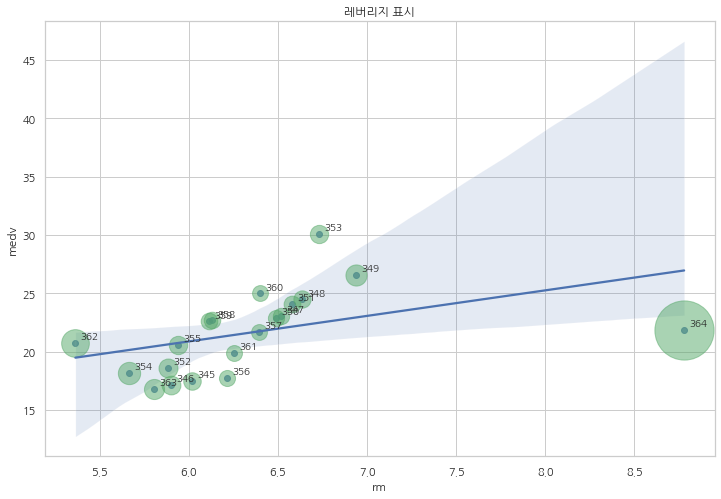

In [6]:
plt.figure(figsize=(12, 8))
sns.regplot(x="rm", y="medv", data=boston20)
for rid, r in boston20.iterrows():
    plt.scatter(r.rm, r.medv, marker="o", alpha=0.5, c="g",
                s=np.round(leverage20.loc[rid] * 5000))
    plt.annotate(rid, (r.rm + 0.03, r.medv + 0.3))
plt.title("레버리지 표시")
plt.show()

레버리지를 영향도라고 부르는 이유는 레버리지 값이 1에 가까운 데이터 즉, <b>레버리지가 큰 데이터는 레버리지가 작은 데이터보다 회귀분석 결과에 영향을 크게 미치기 때문</b>이다.

우리가 사용하는 예제에서 레버리지가 가장 작은 데이터는 357번 데이터이고 레버리지가 가장 큰 데이터는 364번 데이터다.

In [7]:
idx_all = leverage20.index
idx_min = idx_all[leverage20.leverage.argmin()]
idx_max = idx_all[leverage20.leverage.argmax()]
idx_min, idx_max

(357, 364)

이 두가지 데이터를 각각 제외하고 다시 선형회귀분석을 해보자.

In [8]:
ids_min = list(boston20.index.copy())
ids_max = list(boston20.index.copy())
ids_min.remove(idx_min)
ids_max.remove(idx_max)
boston20min = boston20.loc[ids_min]
boston20max = boston20.loc[ids_max]

result20min = sm.OLS.from_formula("medv ~ scale(rm)", boston20min).fit()
result20max = sm.OLS.from_formula("medv ~ scale(rm)", boston20max).fit()

선형회귀분석 결과인 가중치를 비교하면 레버리지가 작은 6번 데이터를 제외하였을 경우에는 큰 차이가 없지만 레버리지가 큰 8번 데이터를 제외한 경우에는 가중치가 많이 달라지는 것을 알 수 있다.

In [9]:
pd.concat(
    [
        result20.params.rename("전체 데이터 사용"),
        result20min.params.rename("가장 레버러지가 작은 데이터 제외"),
        result20max.params.rename("가장 레버러지가 큰 데이터 제외"),
    ], axis=1
)

,전체 데이터 사용,가장 레버러지가 작은 데이터 제외,가장 레버러지가 큰 데이터 제외
Intercept,21.630000,21.626316,21.615789
scale(rm),1.479701,1.518115,2.615438


예측 직선을 그림으로 표시하면 더 알기쉽다. 레버리지가 큰 데이터를 제외하였을 때 기울기가 크게 달라지는 것을 볼 수 있다.

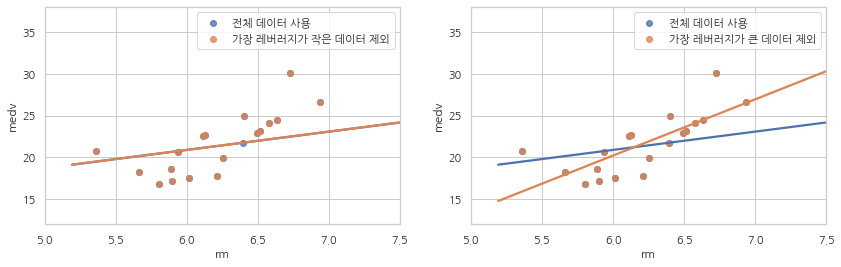

In [10]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
sns.regplot(x="rm", y="medv", ci=None, truncate=False, data=boston20, label="전체 데이터 사용")
sns.regplot(x="rm", y="medv", ci=None, truncate=False, data=boston20min, label="가장 레버러지가 작은 데이터 제외")
plt.xlim(5, 7.5)
plt.ylim(12, 38)
plt.legend()
plt.subplot(122)
sns.regplot(x="rm", y="medv", ci=None, truncate=False, data=boston20, label="전체 데이터 사용")
sns.regplot(x="rm", y="medv", ci=None, truncate=False, data=boston20max, label="가장 레버러지가 큰 데이터 제외")
plt.xlim(5, 7.5)
plt.ylim(12, 38)
plt.legend()
plt.show()

## 잔차

앞에서 가중치 검정을 공부할 때 몇가지 확률론적 가정을 사용하였다. ({ref}`subsection:linear-regression-probabilistic-assumptions` 참조)

그 중 가장 핵심적은 내용은 교란항의 정규성 가정이다.

> 교란항 $\varepsilon$은 기댓값이 0이고 분산이 $\sigma^2$인 정규분포를 따른다. 이 때 교란항의 분산 $\sigma^2$은 어떤 경우에도 변하지 않는다.  

이를 수식으로 표현하면 다음과 같다.

$$ \varepsilon \sim \mathcal{N}(0, \sigma^2) $$
    
교란항의 정규성 가정을 포함한 확률론적 가정을 사용하면 잔차에 대한 다음 두가지 사실을 수학적으로 증명할 수 있다.

```{admonition} 전체 잔차의 정규성
선형회귀분석으로 나온 $N$개의 전체 잔차 $e$는 기댓값이 0인 정규분포를 따른다. 

$$
e \sim \mathcal{N}\left(0, \sigma_e^2 \right)
$$

이 사실을 이용하면 잔차의 크기로부터 교란항의 분산 $\sigma^2$을 다음과 같이 추정할 수 있다.

$$
\hat{\sigma}^2 = \dfrac{e^Te}{N-K-1} = \dfrac{RSS}{N-K-1}
$$
```

```{admonition} 개별 잔차의 정규성
$i$번째 개별 데이터에 대한 잔차 $e_i$도 기댓값이 0인 정규분포를 따른다.

$$
e_i \sim \mathcal{N}\left(0, \sigma_{e,i}^2 \right)
$$

하지만 $i$번째 개별 데이터의 잔차 $e_i$의 분산 $\sigma_{e,i}^2$은 $i$번째 데이터의 레버리지 $h_i$의 영향을 받아서 데이터마다 달라진다. 

$$
\sigma_{e,i}^2 = \hat{\sigma}^2 (1 - h_i)
$$
```

위에서 서술한 두번째 사실로 인해 개별 잔차의 크기를 비교할 때 다음과 같이 개별 데이터의 표준편차로 나누어 표준화를 해야지만 올바른 비교가 가능하다. 

$$ 
r_i = \dfrac{e_i}{\hat{\sigma}\sqrt{1 - h_i}}
$$

이렇게 개별 데이터의 표준편차로 나누어준 잔차 $r_i$를 <b>스튜던트화 잔차(studentized residual)</b>라고 한다. 

영향도 객체는 `resid_studentized` 또는 `resid_studentized_internal` 속성에 스튜던트화 잔차를 가지고 있다. 

In [11]:
resid_stu20 = influence20.resid_studentized
resid_stu20

array([-1.10401894, -1.12476119,  0.34555775,  0.71372182,  1.19508941,
        0.2994623 ,  0.62324626, -0.66184396,  2.46057847, -0.64440242,
       -0.05024419, -1.14097612, -0.01882388,  0.4904032 ,  0.46899524,
        1.0363967 , -0.49478783,  0.44093668, -1.19354705, -2.89971256])

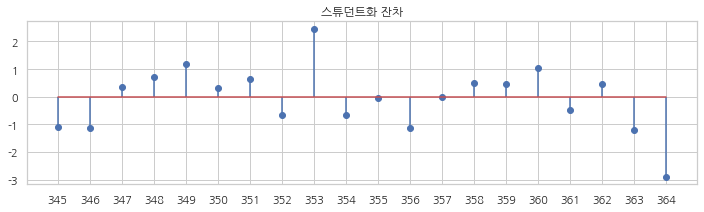

In [12]:
f, ax = plt.subplots(figsize=(12, 3))
ax.stem(idx_all, resid_stu20)
ax.set_xticks(idx_all)
plt.title("스튜던트화 잔차")
plt.show()

이와 비슷한 것으로 <b>외부 스튜던트화 잔차(externally studentized residual)</b> 혹은 SDR(studentized deleted residual)라 부르는 것이 있다. 외부 스튜던트화 잔차는 $i$번째 데이터 레코드의 외부 스튜던트화 잔차는 해당 데이터 레코드($i$번째 데이터 레코드)를 제외한 나머지 데이터만 가지고 다시 선형회귀분석을 하여 계산한 잔차를 해당 잔차의 분산으로 나눈 값이다. 이러한 계산 방식을 <b>LOO(Leave-One-Out) 방식</b>이라고 한다. $i$번째 데이터 레코드의 외부 스튜던트화 잔차 $t_i$를 구하는 식은 다음과 같다.

$$
t_i = \dfrac{y_i - \hat{y}_{(i)}}{\hat{\sigma}_{(i)}}
$$

statsmodels 패키지에서 외부 스튜던트화 잔차를 계산할 때 LOO를 위해 실제로 데이터 개수만큼 선형회귀를 반복하지는 않고 수학적으로 유도된 수식을 이용하여 외부 스튜던트화 잔차를 계산한다. 외부 스튜던트화 잔차는 곧 설명할 아웃라이어 검출에 사용된다. 영향도 객체는 `resid_studentized_external` 속성에 외부 스튜던트화 잔차를 가지고 있다. 

In [13]:
resid_stu_ext20 = influence20.resid_studentized_external
resid_stu_ext20

array([-1.11119486, -1.13363453,  0.33694124,  0.70364089,  1.21043235,
        0.29175272,  0.6123295 , -0.65116874,  2.93534086, -0.63359769,
       -0.048832  , -1.15124175, -0.0182937 ,  0.47980231,  0.45859201,
        1.03866341, -0.48415104,  0.43084662, -1.20873584, -3.8604005 ])

## 아웃라이어

<b>아웃라이어(outlier)</b>는 회귀분석모형으로 예측한 값과 원 데이터 간의 오차 즉, 잔차가 큰 데이터를 말한다. 보통 데이터의 측정/입력 단계 혹은 처리/관리 단계에서 여러가지 실수로 인해 아웃라이어가 발생하는 경우가 많다. 예를 들어 수동으로 데이터를 입력하는 경우에 오타가 발생하던가 입력 데이터의 순서를 바꾸어 넣어서 이런 잘못된 데이터가 발생하는 경우가 흔하다. 따라서  아웃라이어를 검출하여 해당 데이터가 실수로 인해 잘못된 데이터인지 아닌지를 검토해야 한다.

statsmodels 패키지로 선형회귀분석을 실시하여 얻은 분석결과 객체는 아웃라이어를 검출하기 위한 `outlier_test` 메서드를 제공한다. 이 메서드는 아웃라이어 검정(outlier test)을 하는 메서드로 외부 스튜던트화 잔차의 확률분포를 이용하여 주어진 유의수준(지정하지 않은 경우 디폴트 5%) 미만인 데이터를 찾아낸다. 이 때 일반 유의확률이 아닌 <b>본페로니 수정(Bonferroni correction)</b>을 거친 유의확률을 사용해야 한다. 

`outlier_test` 메서드를 호출하면 다음과 같은 데이터프레임을 출력한다. 결과 데이터프레임에서 `bonf(p)` 열이 본페로니 수정 유의확률이다. 아웃라이어 검정은 "아웃라이어가 아니다"라는 귀무가설을 사용하므로 유의확률이 작은 데이터가 아웃라이어가 된다. 364번 데이터의 유의확률이 5% 미만이므로 이 데이터가 아웃라이어가 된다.

In [14]:
result20.outlier_test()

,student_resid,unadj_p,bonf(p)
345,-1.111195,0.281954,1.000000
346,-1.133635,0.272682,1.000000
347,0.336941,0.740285,1.000000
348,0.703641,0.491182,1.000000
349,1.210432,0.242674,1.000000
350,0.291753,0.774006,1.000000
351,0.612329,0.548423,1.000000
352,-0.651169,0.523643,1.000000
353,2.935341,0.009243,0.184858
354,-0.633598,0.534776,1.000000


아웃라이어를 제외한 회귀분석 결과는 다음과같다.

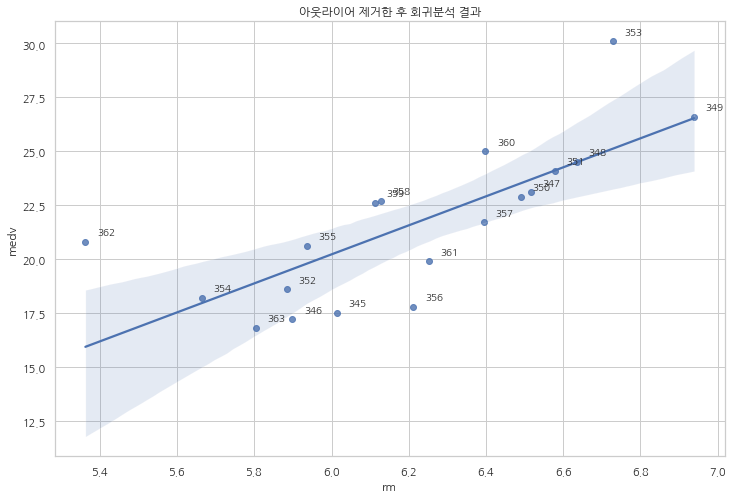

In [15]:
plt.figure(figsize=(12, 8))
sns.regplot(x="rm", y="medv", data=boston20max)
for i, r in boston20max.iterrows():
    plt.annotate(i, (r.rm + 0.03, r.medv + 0.3))
plt.title("아웃라이어 제거한 후 회귀분석 결과")
plt.show()

In [16]:
print(result20max.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     22.46
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           0.000190
Time:                        20:39:11   Log-Likelihood:                -42.583
No. Observations:                  19   AIC:                             89.17
Df Residuals:                      17   BIC:                             91.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.6158      0.552     39.164      0.0

이 때 결정계수가 크게 증가한 것을 알 수 있다.

In [17]:
result20.rsquared, result20max.rsquared

(0.19169107342808145, 0.5691313707164267)

## 영향력 데이터 검출

그런데 아웃라이어 중에서도 레버리지로 대표되는 영향력이 작은 데이터는 사실 제외하든 제외하지 않든 회귀분석 결과에 큰 영향이 없기 때문에 데이터의 개수가 많을 경우 아웃라이어 중에서도 영향력이 큰 데이터만 고려할 수도 있다. 이 때는 스튜던트화 잔차 $r_i$와 레버리지 $h_i$를 동시에 고려하는 <b>쿡 거리(cook's distance)</b>라는 값을 기준으로 사용한다.
    
$$
\text{쿡 거리(cook's distance)} = \dfrac{1}{K + 1}\cdot r_i^2\cdot \dfrac{h_i}{1-h_i}
$$

영향도 객체는 쿡 거리를 `cooks_distance` 속성에 저장한다. 이 때 쿡 거리와 함께 아웃라이어 검정(outlier test)을 위한 유의확률도 같이 저장한다.

In [18]:
cook, pvalues = influence20.cooks_distance
cook

array([3.98120745e-02, 4.83015121e-02, 3.37687385e-03, 1.61850341e-02,
       7.03371904e-02, 2.48869514e-03, 1.16169258e-02, 1.70700103e-02,
       2.16551653e-01, 2.29257190e-02, 9.13217935e-05, 3.54727914e-02,
       9.39903866e-06, 6.96771288e-03, 6.46000187e-03, 2.85151803e-02,
       6.54977100e-03, 1.76334738e-02, 6.27890695e-02, 9.89104790e+00])

쿡 거리를 플롯으로 표시하면 364번 데이터의 잔차가 다른 데이터에 비해 훨씬 크다는 것을 알 수 있다.

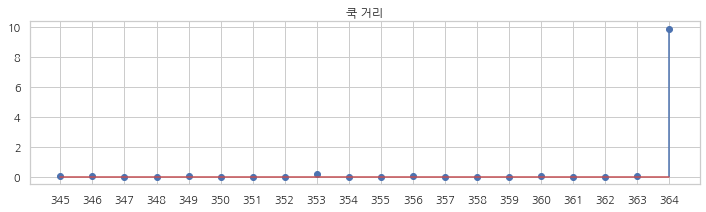

In [19]:
f, ax = plt.subplots(figsize=(12, 3))
ax.stem(idx_all, cook)
ax.set_xticks(idx_all)
plt.title("쿡 거리")
plt.show()

statsmodels 패키지는 각 데이터의 외부 스튜던트 잔차와 레버리지, 쿡 거리를 동시에 시각화하는 `influence_plot` 함수도 제공한다. 이 함수는 각 데이터 레코드의 외부 스튜던트 잔차를 y축에, 레버리지를 x축에 표시한다. 쿡 거리는 데이터 포인트의 원형 크기로 표시한다.

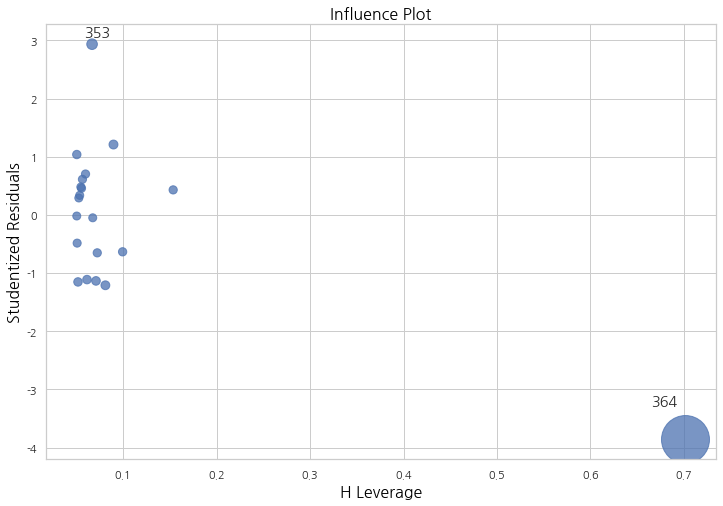

In [20]:
f, ax = plt.subplots(figsize=(12, 8))
sm.graphics.influence_plot(result20, ax=ax)
plt.show()

외부 스튜던트화 잔차를 사용한 <b>DFFITS(DiFference in FITS)</b>라는 값을 사용할 수도 있다. DFFITS는 다음과 같이 정의한다.

$$
\text{DFFITS} = t_i \sqrt{\dfrac{h_i}{1 - h_i}}
$$

dffits 값은 영향도 객체의 `dffits` 속성에 저장되어 있다.

In [21]:
dffits, pvalues = influence20.dffits
dffits

array([-2.84011617e-01, -3.13262278e-01,  8.01319952e-02,  1.77375609e-01,
        3.79881052e-01,  6.87343148e-02,  1.49756645e-01, -1.81789932e-01,
        7.85085705e-01, -2.10539165e-01, -1.31347218e-02, -2.68752589e-01,
       -4.21356016e-03,  1.15496589e-01,  1.11144857e-01,  2.39332604e-01,
       -1.11992752e-01,  1.83497604e-01, -3.58879687e-01, -5.92125226e+00])

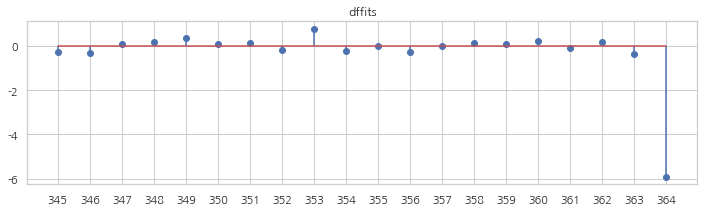

In [22]:
f, ax = plt.subplots(figsize=(12, 3))
ax.stem(idx_all, dffits)
ax.set_xticks(idx_all)
plt.title("dffits")
plt.show()